In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb
from raccoon.utils.annotationutils import trigger_points

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np

# Clean ECG Signals
signal_dir = "../data/mitdb"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119"
])
sampto = 5000

clean_records, triggers = read_records(signal_dir, names, sampto)
clean_records, triggers = np.array(clean_records), np.array(triggers)

# Noise template
noise_path = '../data/noises/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from raccoon.utils.noiseutils import apply_noise_db

snr = 6

noisy_records = np.array([
    apply_noise_db(clean_record, noise_template, snr)
    for clean_record in clean_records])

## Create Detectors

In [5]:
from raccoon.detectors import XiangDetector, RXDetector

zero_drop = XiangDetector(
    name="ZeroDrop",
    window_size=100,
    detection_size=50,
    batch_size=32,
    aux_ratio=5,
    epochs=3)

half_drop = RXDetector(
    name="HalfDrop",
    window_size=100,
    detection_size=50,
    batch_size=32,
    aux_ratio=5,
    epochs=3,
    input_dropout=0.5,
    conv_dropout=0.5)

Using TensorFlow backend.


## Train and Test

In [6]:
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut
from raccoon.utils.evaluationutils import trigger_metrics 

zero_drop_metrics, half_drop_metrics = [], []
cv = LeaveOneOut()

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}: {}".format(step_id, cv.get_n_splits(names), test_indexes))
    
    # Training
    train_records = clean_records[train_indexes]
    train_triggers = triggers[train_indexes]
    zero_drop.reset()
    half_drop.reset()
    with redirect_stdout(StringIO()):
        zero_drop.train(train_records, train_triggers)
        half_drop.train(train_records, train_triggers)
        
    # Testing
    test_record = noisy_records[test_indexes][0]
    test_trigger = triggers[test_indexes][0]
    zero_drop_trigger = zero_drop.trigger(test_record)
    half_drop_trigger = half_drop.trigger(test_record)
    zero_drop_metrics.append(trigger_metrics(test_trigger, zero_drop_trigger, 5))
    half_drop_metrics.append(trigger_metrics(test_trigger, half_drop_trigger, 5))

Step 1/19: [0]
Step 2/19: [1]
Step 3/19: [2]
Step 4/19: [3]
Step 5/19: [4]
Step 6/19: [5]
Step 7/19: [6]
Step 8/19: [7]
Step 9/19: [8]
Step 10/19: [9]
Step 11/19: [10]
Step 12/19: [11]
Step 13/19: [12]
Step 14/19: [13]
Step 15/19: [14]
Step 16/19: [15]
Step 17/19: [16]
Step 18/19: [17]
Step 19/19: [18]


In [7]:
from raccoon.utils.evaluationutils import sensitivity, ppv, f1

zero_drop_ses = [sensitivity(tp, fn) for tp, tn, fp, fn in zero_drop_metrics]
half_drop_ses = [sensitivity(tp, fn) for tp, tn, fp, fn in half_drop_metrics]

zero_drop_ppvs = [ppv(tp, fp) for tp, tn, fp, fn in zero_drop_metrics]
half_drop_ppvs = [ppv(tp, fp) for tp, tn, fp, fn in half_drop_metrics]

zero_drop_f1s = [f1(tp, fp, fn) for tp, tn, fp, fn in zero_drop_metrics]
half_drop_f1s = [f1(tp, fp, fn) for tp, tn, fp, fn in half_drop_metrics]

In [8]:
import numpy as np

metrics = ('Se', 'PPV', 'F1')

zero_drop_means = [
    np.nanmean(zero_drop_ses),
    np.nanmean(zero_drop_ppvs),
    np.nanmean(zero_drop_f1s)]

half_drop_means = [
    np.nanmean(half_drop_ses),
    np.nanmean(half_drop_ppvs),
    np.nanmean(half_drop_f1s)]

zero_drop_stds = [
    np.nanstd(zero_drop_ses),
    np.nanstd(zero_drop_ppvs),
    np.nanstd(zero_drop_f1s)]

half_drop_stds = [
    np.nanstd(half_drop_ses),
    np.nanstd(half_drop_ppvs),
    np.nanstd(half_drop_f1s)]

In [9]:
from scipy.stats import ttest_ind

print("Se : {}".format(ttest_ind(zero_drop_ses, half_drop_ses, nan_policy='omit')))
print("PPV: {}".format(ttest_ind(zero_drop_ppvs, half_drop_ppvs, nan_policy='omit')))
print("F1 : {}".format(ttest_ind(zero_drop_f1s, half_drop_f1s, nan_policy='omit')))

Se : Ttest_indResult(statistic=1.333975315915256, pvalue=0.19059006718167518)
PPV: Ttest_indResult(statistic=0.5187141676887914, pvalue=0.6072244250392056)
F1 : Ttest_indResult(statistic=0.8606117358249205, pvalue=0.39514756160078623)


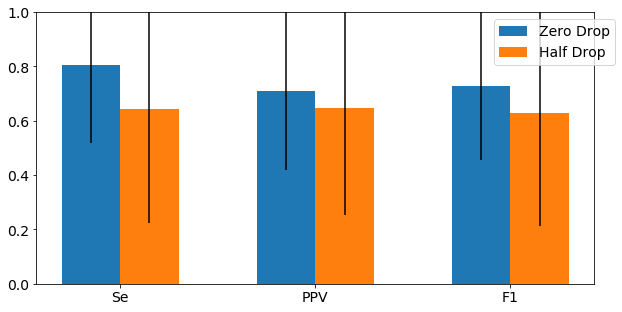

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

bar_width = 0.3
index = np.arange(3) # Se, PPV, F1

ax.bar(index, zero_drop_means, bar_width, yerr=zero_drop_stds, label="Zero Drop")
ax.bar(index+bar_width, half_drop_means, bar_width, yerr=half_drop_stds, label="Half Drop")

ax.set_xticks(index + 0.5*bar_width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)

ax.legend(bbox_to_anchor=(1.05, 1))

plt.show()

In [11]:
zero_drop_metrics

[(17, 0, 0, 0),
 (16, 0, 1, 0),
 (16, 0, 1, 1),
 (15, 0, 1, 1),
 (15, 0, 1, 3),
 (19, 0, 0, 0),
 (13, 0, 9, 1),
 (7, 0, 28, 10),
 (4, 0, 0, 11),
 (18, 0, 11, 4),
 (7, 0, 9, 9),
 (18, 0, 13, 2),
 (13, 0, 2, 0),
 (11, 0, 1, 1),
 (14, 0, 1, 0),
 (18, 0, 10, 0),
 (0, 0, 39, 12),
 (16, 0, 12, 1),
 (14, 0, 25, 1)]

In [12]:
half_drop_metrics

[(17, 0, 0, 0),
 (16, 0, 0, 0),
 (16, 0, 1, 1),
 (15, 0, 1, 1),
 (15, 0, 1, 3),
 (3, 0, 20, 16),
 (13, 0, 1, 1),
 (15, 0, 10, 2),
 (0, 0, 0, 15),
 (0, 0, 2, 22),
 (1, 0, 14, 15),
 (0, 0, 6, 20),
 (13, 0, 0, 0),
 (8, 0, 5, 4),
 (14, 0, 0, 0),
 (18, 0, 1, 0),
 (0, 0, 15, 12),
 (15, 0, 3, 2),
 (14, 0, 5, 1)]